<a href="https://colab.research.google.com/github/adamserag1/Interpretability-for-VRDU-models/blob/main/finetuning/BROS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BROS

## Imports etc.

In [1]:
# UNCOMMNET FOR USE IN COLAB
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 60 (delta 21), reused 14 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 708.21 KiB | 2.28 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [1]:
!pip install transformers torch datasets evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 42.2 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image,ImageDraw, ImageFont
from datasets import load_dataset
import pandas as pd
import evaluate
from transformers import BrosProcessor, BrosSpadeEEForTokenClassification, AutoTokenizer

## Data

In [3]:
funsd = load_dataset("nielsr/funsd", trust_remote_code=True)
label_list = funsd["train"].features["ner_tags"].feature.names
id2label = {v:k for v,k in enumerate(label_list)}
label2id = {k:v for v,k in enumerate(label_list)}

print(funsd["train"]["words"][0])
print(funsd["train"]["ner_tags"][0])
id_0_ner_tags = [id2label[id] for id in funsd["train"]["ner_tags"][0]]
print(id_0_ner_tags)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd.py:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'performed', 'on', 'licen

In [4]:
processor = BrosProcessor.from_pretrained("naver-clova-ocr/bros-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("naver-clova-ocr/bros-base-uncased",do_lower_case=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

In [5]:
sample = funsd["train"][66]
image = Image.open(sample["image_path"]).convert("RGB")
print(sample['words'])

['NAME', 'STRUCTURE', 'II', 'COMMENTS', 'A41', '00838511', 'DATE', 'DECISION', 'TREE', 'ESTIMATION', 'OF', 'TOXIC', 'RISK', 'Paul', 'Schickedantz,', 'Jack', 'Reid', '12-', '4-', '80', 'COMPOUND', 'NAME', '2-Hydroxycyclododecanone', 'OH', 'O', 'ESTIMATED', 'TOXICITY', 'CLASS', 'LORILLARD', 'COMPOUND', 'CODE', 'NUMBER', 'This', 'carbocyclic', 'keto', 'alcohol', 'was', 'placed', 'in', 'estimated', 'toxicity', 'class', 'II', 'due', 'to', 'the', 'direct', 'attachment', 'of', 'the', 'ketone', 'to', 'the', 'cyclic', 'nucleus.', 'LORILLARD', 'RESEARCH', 'CENTER', 'FORM', '1', '(580)']


In [6]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def tokenize_words(batch):
  encodings = tokenizer(
    batch["words"],
    is_split_into_words=True,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
  )

  batch_normalized_bboxes, encoded_labels = [], []
  for idx, (bboxes, img_path, labels) in enumerate(zip(batch["bboxes"], batch["image_path"], batch["ner_tags"])):
    width, height = Image.open(img_path).size
    normalized_bboxes = [normalize_bbox(bbox, width, height) for bbox in bboxes]

    # Align boxes to sub words
    aligned_boxes, aligned_labels = [], []
    for word_id in encodings.word_ids(batch_index=idx):
      if word_id is None:
        aligned_boxes.append([0, 0, 0, 0])
        aligned_labels.append(-100)
      else:
        aligned_boxes.append(normalized_bboxes[word_id])
        aligned_labels.append(labels[word_id])

    batch_normalized_bboxes.append(aligned_boxes)
    encoded_labels.append(aligned_labels)

  encodings['bbox'] = batch_normalized_bboxes
  encodings['labels'] = encoded_labels

  return encodings

In [7]:
train_dataset = funsd["train"].map(tokenize_words, batched=True, remove_columns=funsd["train"].column_names)
val_dataset = funsd["test"].map(tokenize_words, batched=True, remove_columns=funsd["train"].column_names)

train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

## Finetuning

In [18]:
from transformers import AutoModelForTokenClassification, BrosForTokenClassification
model = BrosForTokenClassification.from_pretrained("naver-clova-ocr/bros-base-uncased", num_labels=len(label_list), id2label=id2label, label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BrosForTokenClassification were not initialized from the model checkpoint at naver-clova-ocr/bros-base-uncased and are newly initialized: ['bros.bbox_embeddings.bbox_projection.weight', 'bros.bbox_embeddings.bbox_sinusoid_emb.x_pos_emb.inv_freq', 'bros.bbox_embeddings.bbox_sinusoid_emb.y_pos_emb.inv_freq', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BrosForTokenClassification(
  (bros): BrosModel(
    (embeddings): BrosTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (bbox_embeddings): BrosBboxEmbeddings(
      (bbox_sinusoid_emb): BrosPositionalEmbedding2D(
        (x_pos_emb): BrosPositionalEmbedding1D()
        (y_pos_emb): BrosPositionalEmbedding1D()
      )
      (bbox_projection): Linear(in_features=192, out_features=64, bias=False)
    )
    (encoder): BrosEncoder(
      (layer): ModuleList(
        (0-11): 12 x BrosLayer(
          (attention): BrosAttention(
            (self): BrosSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Lin

In [19]:
from transformers import TrainingArguments, Trainer, DefaultDataCollator
training_args = TrainingArguments(
    output_dir="./bros-funsd-finetuned",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model="eval_f1",
)

# Data collator
data_collator = DefaultDataCollator(return_tensors="pt")

In [20]:
metric = evaluate.load("seqeval")
import numpy as np
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=-1)

  true_preds = [
      [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  results = metric.compute(predictions=true_preds, references=true_labels)

  return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
  }

In [14]:
from transformers import EarlyStoppingCallback
early_stop = EarlyStoppingCallback(
    early_stopping_patience   = 5,
    early_stopping_threshold  = 0.0,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

In [25]:
'''
Model available on huggingface hub: https://huggingface.co/adamadam111/bros-finetuned-funsd
'''

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

events.out.tfevents.1745781798.7eedab0c2041.686.0:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

events.out.tfevents.1745782363.7eedab0c2041.686.1:   0%|          | 0.00/53.3k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/adamadam111/bros-funsd-finetuned/commit/69e6211ba94169a93e791a37851a5e8a4b3323c6', commit_message='adamadam1/bros-funsd-finetuned', commit_description='', oid='69e6211ba94169a93e791a37851a5e8a4b3323c6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/adamadam111/bros-funsd-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='adamadam111/bros-funsd-finetuned'), pr_revision=None, pr_num=None)

## Inference

Upload a test form as 'test.jpg' for inference

In [27]:
!pip install pytesseract

In [36]:
import pytesseract, cv2

tokenizer = AutoTokenizer.from_pretrained("adamadam111/bros-funsd-finetuned",do_lower_case=True)
model = BrosForTokenClassification.from_pretrained("adamadam111/bros-funsd-finetuned")

image_path = "test.jpg"
img = cv2.imread(image_path)
ocr_data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [29]:
words, bboxes = [], []
for i in range(len(ocr_data["text"])):
  word = ocr_data["text"][i].strip()
  if word == "":
    continue
  x, y, w, h = (ocr_data[k][i] for k in ["left","top","width","height"])
  words.append(word)
  bboxes.append([x, y, x+w, y+h])


In [58]:
height, width = img.shape[:2]
boxes_1000 = [normalize_bbox(bbox, width, height) for bbox in bboxes]


In [60]:
enc = tokenizer(words,
          is_split_into_words=True,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=512)

aligned_boxes = []
word_ids = enc.word_ids()
for wi in word_ids:
  if wi is None:
    aligned_boxes.append([0,0,0,0])
  else:
    aligned_boxes.append(boxes_1000[wi])

enc["bbox"] = torch.tensor([aligned_boxes])


In [61]:
def unnormalize_box(box_1000, w, h):
  return [
    int(box_1000[0] * w / 1000),
    int(box_1000[1] * h / 1000),
    int(box_1000[2] * w / 1000),
    int(box_1000[3] * h / 1000),
  ]

def iob_to_label(tag):
  print(tag)
  core = tag[2:] if tag.startswith(("B-","I-")) else tag
  return core.lower() if core else "other"

label2color = {
  "question": "blue",
  "answer":   "green",
  "header":   "orange",
  "other":    "violet",
}

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


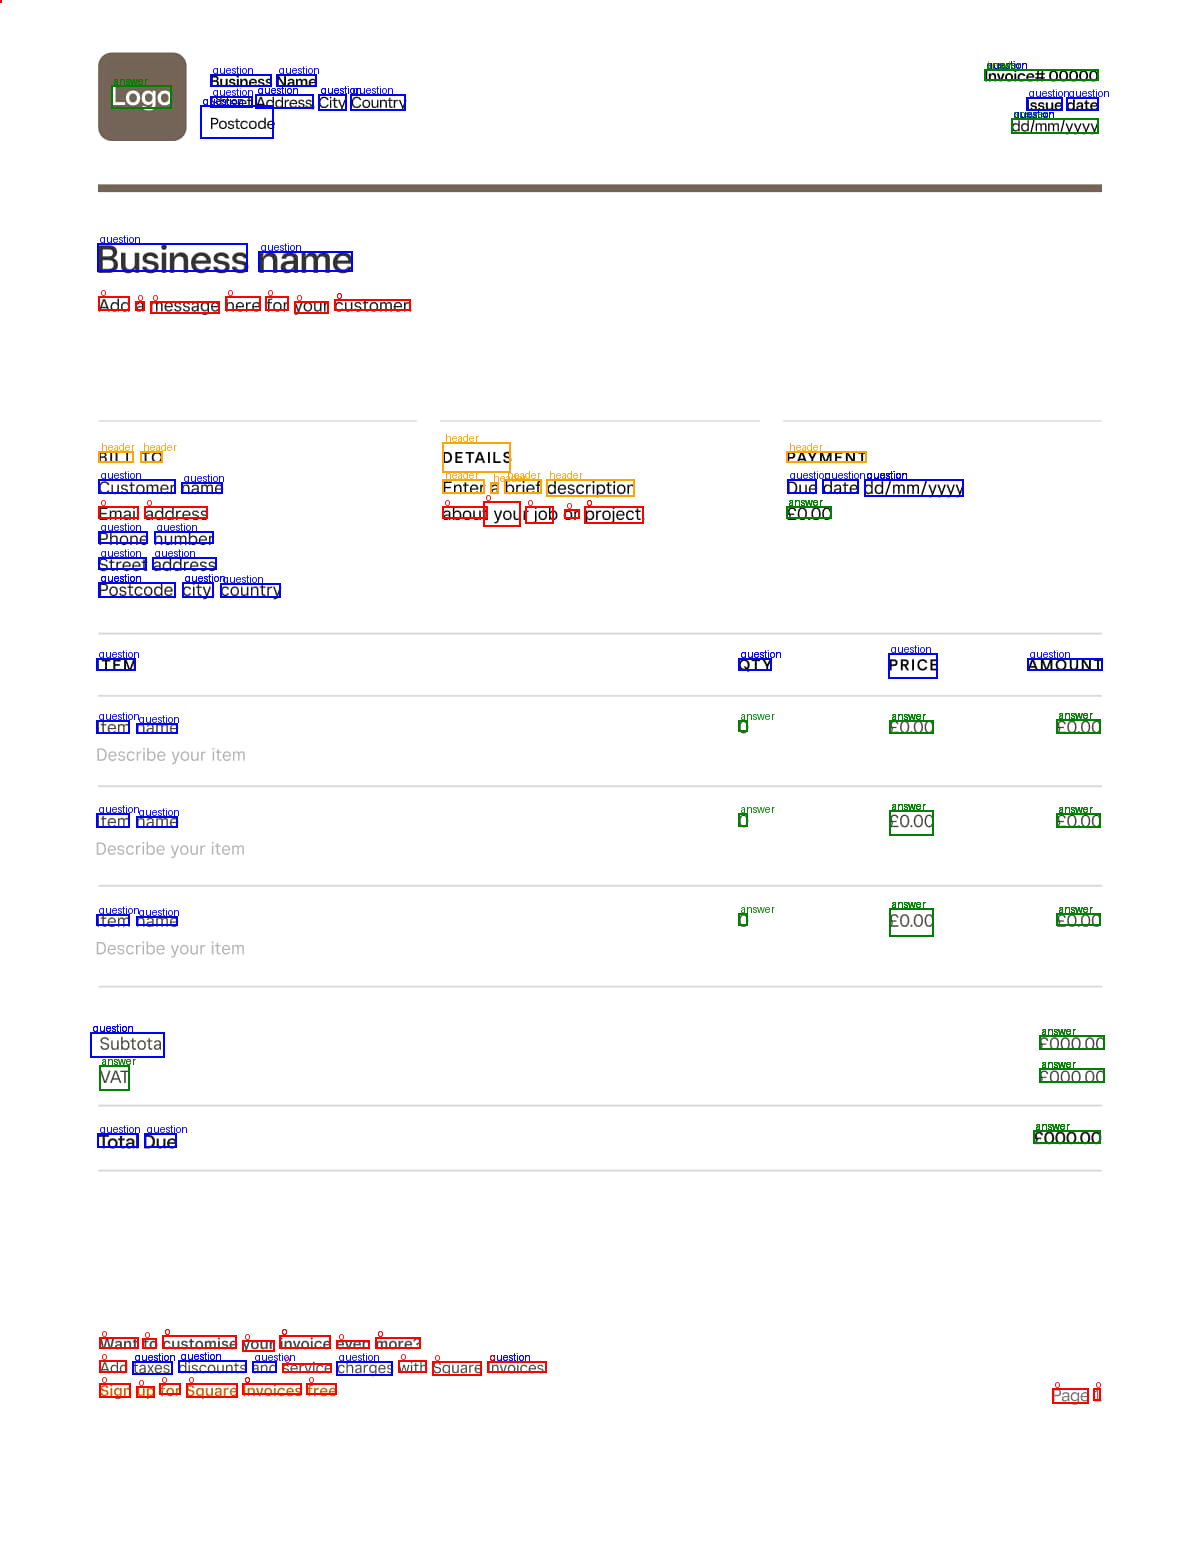

In [62]:
outputs   = model(**enc)
pred_ids  = outputs.logits.argmax(dim=-1).squeeze().tolist()
word_ids  = enc.word_ids()

true_preds, true_boxes = [], []
prev_word = None
for pid, wid, box in zip(pred_ids, word_ids, aligned_boxes):
  if wid is None or wid == prev_word:
    continue
  true_preds.append(id2label[pid])
  true_boxes.append(unnormalize_box(box, width, height))
  prev_word = wid

true_preds = [id2label[p] for p, l in zip(pred_ids, word_ids) if l != -100]
true_boxes = [unnormalize_box(b, width, height) for b, l in zip(aligned_boxes, word_ids) if l != -100]

img_pil = Image.fromarray(img)
draw = ImageDraw.Draw(img_pil)
font = ImageFont.load_default()

for pred, box in zip(true_preds, true_boxes):
  label = iob_to_label(pred)
  color = label2color.get(label, "red")
  draw.rectangle(box, outline=color, width=2)
  draw.text((box[0] + 3, box[1] - 10), text=label, fill=color, font=font)

img_pil
#img_pil.save('/content/test_ann.jpg')